In [141]:
import glob
import h5py
import matplotlib.pyplot as plt 
import numpy as np 
import os
import pickle
import random

from omegaconf import OmegaConf
from holobot.robot.allegro.allegro_kdl import AllegroKDL
from tactile_learning.utils.visualization import plot_tactile_sensor

In [158]:
# Script to get random tactile information and the fingertip positions and
# visualize them

class KNNVisualizer:
    def __init__(
        self,
        data_path,
        sensor_indices = (3,7),
        allegro_finger_indices = (0,1)
    ):
        self.data_path = data_path

        self.sensor_indices = sensor_indices 
        self.allegro_finger_indices = [j for i in allegro_finger_indices for j in range(i*3,(i+1)*3)]

        # Get the data
        self._load_data()

        self.idx = 2000

    def _load_data(self):
        roots = glob.glob(f'{self.data_path}/demonstration_*')
        roots = sorted(roots)

        self.tactile_indices = [] 
        self.allegro_indices = []
        self.tactile_values = []
        self.allegro_tip_positions = [] 
        self.tactile_timestamps = []
        self.allegro_timestamps = []

        for root in roots:
            # Load the indices
            with open(os.path.join(root, 'tactile_indices.pkl'), 'rb') as f:
                self.tactile_indices += pickle.load(f)
            with open(os.path.join(root, 'allegro_indices.pkl'), 'rb') as f:
                self.allegro_indices += pickle.load(f)

            # Load the data
            with h5py.File(os.path.join(root, 'allegro_fingertip_states.h5'), 'r') as f:
                self.allegro_tip_positions.append(f['positions'][()][:, self.allegro_finger_indices])
                self.allegro_timestamps.append(f['timestamps'][()])
            with h5py.File(os.path.join(root, 'touch_sensor_values.h5'), 'r') as f:
                self.tactile_values.append(f['sensor_values'][()][:,self.sensor_indices,:,:])
                self.tactile_timestamps.append(f['timestamps'][()])


        assert len(self.tactile_indices) == len(self.allegro_indices)

    # Method to create a random index and return random allegro
    # fingertip position and a tactile sensor
    def get_example_state(self):
        # Also we will be checking the timestamps as well

        # Get random index
        rand_idx = random.randrange(0, len(self.tactile_indices))

        # Get random tactile value
        demo_id, tactile_id = self.tactile_indices[rand_idx]
        tactile_value = self.tactile_values[demo_id][tactile_id]
        tactile_timestamp = self.tactile_timestamps[demo_id][tactile_id]

        print('tactile_value.shape: {}, tactile_timestamp: {}'.format(
            tactile_value.shape, tactile_timestamp
        ))

        # Get random allegro tip position
        demo_id, allegro_id = self.allegro_indices[rand_idx]
        allegro_tip_pos = self.allegro_tip_positions[demo_id][allegro_id]
        allegro_timestamp = self.allegro_timestamps[demo_id][allegro_id]

        print('allegro_tip_pos.shape: {}, allegro_timestamp: {}'.format(
            allegro_tip_pos.shape, allegro_timestamp
        ))

        return tactile_value, allegro_tip_pos

    def get_ordered_state(self):
        if self.idx >= len(self.tactile_indices):
            self.idx = 2000
        
        self.idx += 20
        
        demo_id, tactile_id = self.tactile_indices[self.idx]
        tactile_value = self.tactile_values[demo_id][tactile_id]
        tactile_timestamp = self.tactile_timestamps[demo_id][tactile_id]

        print('tactile_value.shape: {}, tactile_timestamp: {} [{},{}]'.format(
            tactile_value.shape, tactile_timestamp, demo_id, tactile_id
        ))

        # Get random allegro tip position
        demo_id, allegro_id = self.allegro_indices[self.idx]
        allegro_tip_pos = self.allegro_tip_positions[demo_id][allegro_id]
        allegro_timestamp = self.allegro_timestamps[demo_id][allegro_id]

        print('allegro_tip_pos.shape: {}, allegro_timestamp: {} [{},{}]'.format(
            allegro_tip_pos.shape, allegro_timestamp, demo_id, allegro_id
        ))

        return tactile_value, allegro_tip_pos

    


In [159]:
knn_visualizer = KNNVisualizer(
    data_path='/home/irmak/Workspace/Holo-Bot/extracted_data/joystick'
)

In [160]:
tactile_value, allegro_tip_pos = knn_visualizer.get_example_state()

tactile_value.shape: (2, 16, 3), tactile_timestamp: 1670206038.3906214
allegro_tip_pos.shape: (6,), allegro_timestamp: 1670206038.3908546


In [161]:
def plot_fingertip_position(ax, tip_position, finger_index): 
    # Tip position: (3,) - (x,y,z) positions of the tip
    # finger_index: 0 or 1
    types = ['X', 'Y', 'Z']
    values = tip_position 

    ax.set_ylim(-0.05, 0.15)
    if finger_index == 0: # The index finger 
        ax.bar(types, values, color='darkolivegreen')
        ax.set_title('Index Finger Tip Position')
    elif finger_index == 1:
        ax.bar(types, values, color='mediumturquoise')
        ax.set_title('Middle Finger Tip Position')
    
    

In [162]:
def dump_tactile_state(tactile_value, allegro_tip_pos, title='Nearest Neighbor'):
    # tactile_value: (2,16,3)
    # allegro_tip_pos: (6,)
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
    plot_tactile_sensor(axs[0,0], tactile_value[0,:,:], title='Index Tip Tactile Sensors')
    plot_tactile_sensor(axs[0,1], tactile_value[1,:,:], title='Middle Tip Tactile Sensors')
    plot_fingertip_position(axs[1,0], allegro_tip_pos[0:3], 0)
    plot_fingertip_position(axs[1,1], allegro_tip_pos[3:], 1)
    fig.suptitle(title)
    plt.show()
    fig.savefig(f'{title}.png')
    fig.clf()

    return fig, axs


tactile_value.shape: (2, 16, 3), tactile_timestamp: 1670206041.8915246 [4,491]
allegro_tip_pos.shape: (6,), allegro_timestamp: 1670206041.8941538 [4,1855]


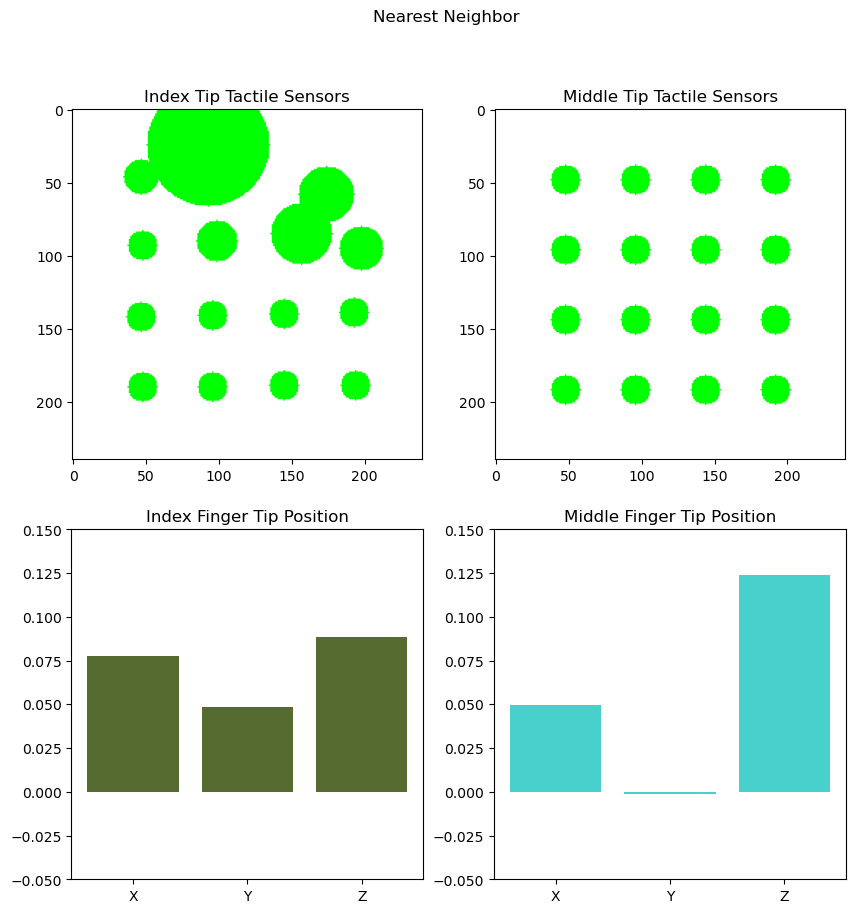

In [202]:
tactile_value, allegro_tip_pos = knn_visualizer.get_ordered_state()
fig, _ = dump_tactile_state(tactile_value, allegro_tip_pos) 
    

In [122]:
# Script to look at the current image
from holobot.constants import CAM_FPS, DEPTH_RECORD_FPS, IMAGE_RECORD_RESOLUTION
from holobot.utils.files import store_pickle_data
from holobot.utils.network import ZMQCameraSubscriber

In [13]:
import cv2

def dump_camera_image(host, image_stream_port):
    image_subscriber = ZMQCameraSubscriber(
        host = host,
        port = image_stream_port,
        topic_type = 'RGB'
    )
    image, timestamp = image_subscriber.recv_rgb_image()
    cv2.imwrite('Camera Image.png', image)

# Camera offsets
host = '172.24.71.240'
image_stream_port = 10005
dump_camera_image(host, image_stream_port)

In [14]:
# Get two random tactile positions and tip positions and dump them
curr_tactile_value, curr_tip_pos = knn_visualizer.get_example_state()
knn_tactile_value, knn_tip_pos = knn_visualizer.get_example_state()

tactile_value.shape: (2, 16, 3), tactile_timestamp: 1669824220.5321686
allegro_tip_pos.shape: (6,), allegro_timestamp: 1669824220.544337
tactile_value.shape: (2, 16, 3), tactile_timestamp: 1669824470.1118817
allegro_tip_pos.shape: (6,), allegro_timestamp: 1669824470.1243322


In [15]:
# Dump the current state
dump_tactile_state(curr_tactile_value, curr_tip_pos, title='Current State')
fig, _ = dump_tactile_state(knn_tactile_value, knn_tip_pos, title='Nearest Neighbor')
dump_camera_image(host, image_stream_port)

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

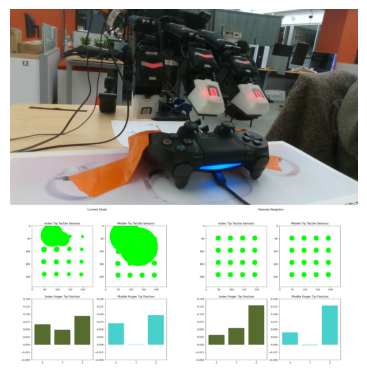

In [17]:
# Read all of them and horizontally stack them
def plot_knn_state():
    curr_state = cv2.imread('Current State.png')
    knn_state = cv2.imread('Nearest Neighbor.png')
    camera_img = cv2.imread('Camera Image.png')

    state_img = cv2.hconcat([curr_state, knn_state])
    width_scale = camera_img.shape[1] / state_img.shape[1]
    state_img = cv2.resize(
        state_img, 
        (int(state_img.shape[1] * width_scale),
         int(state_img.shape[0] * width_scale))
    )

    all_state_img = cv2.vconcat([camera_img, state_img])
    plt.axis('off')
    plt.imshow(cv2.cvtColor(all_state_img, cv2.COLOR_BGR2RGB))

    


    


# curr_state = cv2.imread('Current State.png')
# knn_state = cv2.imread('Nearest Neighbor.png')
# camera_img = cv2.imread('Camera Image.png')
# print('curr_state.shape: {}, knn_state.shape: {}'.format(
#     curr_state.shape, knn_state.shape
# ))
# new_img = cv2.hconcat([curr_state, knn_state])
# width_scale = float(camera_img.shape[1] / (curr_state.shape[1] + knn_state.shape[1]))
# new_width = int(new_img.shape[1] * width_scale)
# new_height = int(new_img.shape[0] * width_scale)
# new_img = cv2.resize(new_img, (new_width, new_height))

# plt.axis('off')
# plt.imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))
# print('new_img.shape: {}, camera_img.shape: {}'.format(
#     new_img.shape, camera_img.shape
# ))
# new_img_2 = cv2.vconcat([camera_img, new_img])
# plt.imshow(cv2.cvtColor(new_img_2, cv2.COLOR_BGR2RGB))

# plt.pause(0.001) # This make the graph show up if matplotlib is in Tkinter mode
# plt.cla()

plot_knn_state()